# (A) Download and preprocess the data

In [ ]:
import pandas as pd
# Read in short-term load data and parse the dates
df = pd.read_csv("/content/DK_STLF_2010_2019-10-31.csv",
                 parse_dates=["Date"],
                 index_col="Date")# parse the date column and tell pandas column 1 is a datetime

In [ ]:
df.head(), df.tail(), df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3591 entries, 2010-01-01 to 2019-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MW8     3591 non-null   float64
dtypes: float64(1)
memory usage: 56.1 KB


(               MW8
 Date              
 2010-01-01  3589.0
 2010-01-02  4039.0
 2010-01-03  3993.0
 2010-01-04  5629.0
 2010-01-05  5703.0,
                 MW8
 Date               
 2019-10-27  3929.79
 2019-10-28  4699.64
 2019-10-29  4836.49
 2019-10-30  5000.82
 2019-10-31  4839.68,
 None)

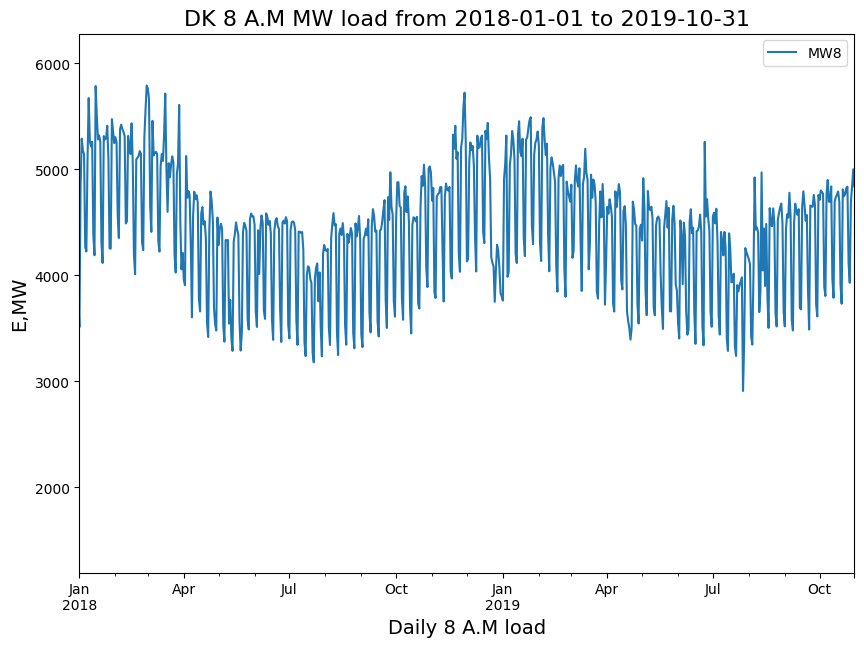

In [ ]:
#Plot from dataframe
import matplotlib.pyplot as plt
df.plot(figsize=(10, 7))
plt.xlim("2018-01-01","2019-10-31") # limit plot to 2018-19
plt.ylabel("E,MW", fontsize=14)
plt.xlabel("Daily 8 A.M load", fontsize=14)
plt.title("DK 8 A.M MW load from 2018-01-01 to 2019-10-31", fontsize=16);

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

# Create timestep and MW numpy arrays for data manipulation
timesteps = df.index.to_numpy()
mw_8 = df['MW8'].to_numpy()

In [ ]:
mw_8[:5], mw_8.shape, timesteps[:5], timesteps.shape

(array([3589., 4039., 3993., 5629., 5703.]),
 (3591,),
 array(['2010-01-01T00:00:00.000000000', '2010-01-02T00:00:00.000000000',
        '2010-01-03T00:00:00.000000000', '2010-01-04T00:00:00.000000000',
        '2010-01-05T00:00:00.000000000'], dtype='datetime64[ns]'),
 (3591,))

## Function to make windows
Make windows using NumPy's array indexing.

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1

In [ ]:
def make_windows(time_series, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequentially labelled windows of
  window_size steps and horizon size labels.
  """
  # Returns [[0 1 2 3 4 5 6 7]] (arange returns an array instead of a list):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # Returns [[0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7], [2, 3, 4, 5, 6, 7, 8]...]]:
  window_indexes = window_step + np.expand_dims(np.arange(len(time_series)-(window_size+horizon-1)), axis=0).T
  # Returns [[3589.  4039.  3993. 5629. 5703. 5641.  5803.  5867. ]...]]
  windowed_array = time_series[window_indexes]
  # Returns [[3589.  4039.  3993.  5629. 5703.  5641.  5803. ]...]] and [[5867. ]...]:
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels


## Function to label windowed data

In [ ]:
def get_labelled_windows(array, horizon):
  """
  Creates labels for windowed datasets. E.g. horizon=1:
  --------
  Input: [[0, 1, 2, 3, 4, 5, 6, 7]]
  Output: ([[0, 1, 2, 3, 4, 5, 6]], [[7]])
  """
  return array[:, :-horizon], array[:, -horizon:]

## Function to split data
Because of the offset, windowing the full dataset first, then splitting it into training and test sets works better. PLotting won't work after windowing, given differing shape size.

In [ ]:
def split_data(windows, labels, test_split=0.2):
  """
  Splits all windows and labels into train and test sets.
  """
  split = int(len(windows) * (1-test_split))
  train_windows, train_labels = windows[:split], labels[:split]
  test_windows, test_labels = windows[split:], labels[split:]

  return train_windows, test_windows, train_labels, test_labels

## Create windows/labels and split data

In [ ]:
all_windows, all_labels = make_windows(mw_8, window_size=WINDOW_SIZE, horizon=HORIZON)
len(all_windows), len(all_labels)

(3584, 3584)

In [ ]:
train_windows, test_windows, train_labels, test_labels = split_data(all_windows, all_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2867, 717, 2867, 717)

# (B) Create model experiments

## Function to forecasts on the test data

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on test windows.
  """
  predictions = model.predict(input_data)
  return tf.squeeze(predictions) # return a 1D array of predictions

## Function on regression metrics

In [ ]:
def evaluate_preds(y_true, y_pred):
  """
  Regression metrics: MAE, MSE, RMSE and MAPE
  """
  y_true = tf.cast(y_true, dtype=tf.float32)# float32 datatype for metric calculations
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  # Account for larger horizons by reducing metrics to a single value
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

## Create callbacks
ModelCheckpoint, EarlyStopping, LearningRateScheduler and ReduceLROnPlateau.

In [ ]:
import os
# Compare models best performances (epoch) with filename
def model_checkpoint(model_name, save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0,
                                            save_best_only=True)

# Stop training when a monitored metric has stopped improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=200,
                                                  restore_best_weights=True)
# Find best learning rate during training - multiply by 10 every 20 epochs
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Reduce learning rate if a model stops improving (take smaller steps towards best performance)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 patience=100,
                                                 verbose=1) # Reduce lr by 0.1 if no val_loss improvement within 100, and stop training

## Optimize window size
Loop through different window sized models to find best fit.

In [ ]:
from tqdm import tqdm # add progress bars to loops

model_results_list = []
model_loss_list = []

# Create models with window size from 7 to 28
for size in tqdm(range(7,29)):
  HORIZON = 1
  WINDOW_SIZE = size

  # Create window and labels
  all_windows, all_labels = make_windows(mw_8, window_size=WINDOW_SIZE, horizon=HORIZON)

  # Split the data
  train_windows, test_windows, train_labels, test_labels = split_data(all_windows, all_labels)

  # Create dense input/output layers using functional API
  tf.random.set_seed(42)
  input = layers.Input(shape=(WINDOW_SIZE,), name='Input_layer')# try dtype = tf.float32 as TF version below
  x = layers.Dense(128, activation='relu')(input)
  output = layers.Dense(HORIZON, activation='linear')(x)

  # Build, compile and fit a simple dense model
  model = tf.keras.Model(input, output, name=f'model_windowed_{size}')
  model.compile(loss='mae', optimizer='adam', metrics='mae')
  model.fit(train_windows, train_labels,
            epochs=100, batch_size=128, verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[model_checkpoint(model_name=model.name)])

  # Make predictions and evaluate the model
  predictions = model.predict(test_windows)
  y_preds = tf.squeeze(predictions)
  results = evaluate_preds(tf.squeeze(test_labels), y_preds)
  model_results_list.append(results)
  # Load best performing epoch and evaluate on test data
  best_epoch = tf.keras.models.load_model(f"model_experiments/model_windowed_{size}/")
  model_loss = best_epoch.evaluate(test_windows, test_labels)
  model_loss_list.append(model_loss)

  0%|          | 0/22 [00:00<?, ?it/s]

23/23 [==============================] - 0s 2ms/step - loss: 169.4616 - mae: 169.4616


  5%|▍         | 1/22 [00:25<08:50, 25.27s/it]

23/23 [==============================] - 0s 2ms/step - loss: 168.5074 - mae: 168.5074


  9%|▉         | 2/22 [01:07<11:50, 35.51s/it]

23/23 [==============================] - 0s 2ms/step - loss: 175.9766 - mae: 175.9766


 14%|█▎        | 3/22 [01:32<09:38, 30.46s/it]

23/23 [==============================] - 0s 2ms/step - loss: 165.0478 - mae: 165.0478


 18%|█▊        | 4/22 [01:54<08:06, 27.03s/it]

23/23 [==============================] - 0s 2ms/step - loss: 176.9726 - mae: 176.9726


 23%|██▎       | 5/22 [02:21<07:39, 27.05s/it]

23/23 [==============================] - 0s 2ms/step - loss: 162.1410 - mae: 162.1410


 27%|██▋       | 6/22 [02:44<06:51, 25.70s/it]

23/23 [==============================] - 0s 2ms/step - loss: 169.4951 - mae: 169.4951


 32%|███▏      | 7/22 [03:06<06:07, 24.53s/it]

23/23 [==============================] - 0s 2ms/step - loss: 163.3054 - mae: 163.3054


 36%|███▋      | 8/22 [03:31<05:44, 24.58s/it]

23/23 [==============================] - 0s 2ms/step - loss: 159.2994 - mae: 159.2994


 41%|████      | 9/22 [03:56<05:21, 24.76s/it]

23/23 [==============================] - 0s 2ms/step - loss: 162.4510 - mae: 162.4510


 45%|████▌     | 10/22 [04:17<04:45, 23.78s/it]

23/23 [==============================] - 0s 1ms/step - loss: 165.3058 - mae: 165.3058


 50%|█████     | 11/22 [04:59<05:22, 29.36s/it]

23/23 [==============================] - 0s 2ms/step - loss: 162.8012 - mae: 162.8012


 55%|█████▍    | 12/22 [05:18<04:21, 26.11s/it]

23/23 [==============================] - 0s 1ms/step - loss: 162.5160 - mae: 162.5160


 59%|█████▉    | 13/22 [05:40<03:43, 24.79s/it]

23/23 [==============================] - 0s 1ms/step - loss: 166.5626 - mae: 166.5626


 64%|██████▎   | 14/22 [06:04<03:17, 24.68s/it]

23/23 [==============================] - 0s 2ms/step - loss: 158.0623 - mae: 158.0623


 68%|██████▊   | 15/22 [06:26<02:46, 23.83s/it]

23/23 [==============================] - 0s 1ms/step - loss: 158.9061 - mae: 158.9061


 73%|███████▎  | 16/22 [06:48<02:18, 23.14s/it]

23/23 [==============================] - 0s 1ms/step - loss: 156.1661 - mae: 156.1661


 77%|███████▋  | 17/22 [07:30<02:24, 28.82s/it]

23/23 [==============================] - 0s 1ms/step - loss: 161.9525 - mae: 161.9525


 82%|████████▏ | 18/22 [08:12<02:11, 32.83s/it]

23/23 [==============================] - 0s 3ms/step - loss: 158.2107 - mae: 158.2107


 86%|████████▋ | 19/22 [08:54<01:46, 35.65s/it]

23/23 [==============================] - 0s 2ms/step - loss: 159.9822 - mae: 159.9822


 91%|█████████ | 20/22 [09:14<01:02, 31.04s/it]

23/23 [==============================] - 0s 1ms/step - loss: 160.5812 - mae: 160.5812


 95%|█████████▌| 21/22 [09:32<00:26, 26.97s/it]

23/23 [==============================] - 0s 1ms/step - loss: 153.4870 - mae: 153.4870


100%|██████████| 22/22 [09:51<00:00, 26.88s/it]


 Model results list: [{'mae': 170.03767, 'mse': 65187.37, 'rmse': 255.31818, 'mape': 3.877471}, {'mae': 168.79323, 'mse': 65050.113, 'rmse': 255.04924, 'mape': 3.8570623}, {'mae': 177.97658, 'mse': 69810.72, 'rmse': 264.2172, 'mape': 4.0397773}, {'mae': 176.1515, 'mse': 65444.72, 'rmse': 255.82166, 'mape': 3.9713387}, {'mae': 183.02875, 'mse': 71861.2, 'rmse': 268.0694, 'mape': 4.146634}, {'mae': 170.87009, 'mse': 63647.832, 'rmse': 252.28522, 'mape': 3.8801956}, {'mae': 180.25641, 'mse': 67811.73, 'rmse': 260.40686, 'mape': 4.1257195}, {'mae': 164.88498, 'mse': 60722.31, 'rmse': 246.41898, 'mape': 3.7330885}, {'mae': 161.51877, 'mse': 60292.246, 'rmse': 245.5448, 'mape': 3.6724105}, {'mae': 164.89874, 'mse': 61755.71, 'rmse': 248.50696, 'mape': 3.721975}, {'mae': 177.7041, 'mse': 66733.2, 'rmse': 258.3277, 'mape': 4.0073304}, {'mae': 234.56993, 'mse': 92059.52, 'rmse': 303.41312, 'mape': 5.447168}, {'mae': 171.4045, 'mse': 64865.336, 'rmse': 254.68674, 'mape': 3.8618863}, {'mae': 194

In [ ]:
model_loss_list # Windows of 21, 22, 23***, 25, 26 and 28*** perform best

[[169.46163940429688, 169.46163940429688],
 [168.5074462890625, 168.5074462890625],
 [175.97662353515625, 175.97662353515625],
 [165.04779052734375, 165.04779052734375],
 [176.97259521484375, 176.97259521484375],
 [162.14102172851562, 162.14102172851562],
 [169.4951171875, 169.4951171875],
 [163.30538940429688, 163.30538940429688],
 [159.2994384765625, 159.2994384765625],
 [162.4510498046875, 162.4510498046875],
 [165.30577087402344, 165.30577087402344],
 [162.80123901367188, 162.80123901367188],
 [162.51602172851562, 162.51602172851562],
 [166.5626220703125, 166.5626220703125],
 [158.06227111816406, 158.06227111816406],
 [158.9061279296875, 158.9061279296875],
 [156.1660614013672, 156.1660614013672],
 [161.95245361328125, 161.95245361328125],
 [158.21072387695312, 158.21072387695312],
 [159.98220825195312, 159.98220825195312],
 [160.5812225341797, 160.5812225341797],
 [153.48696899414062, 153.48696899414062]]

In [ ]:
model_results_list # Windows of 15, 21*** and 25 perform best

[{'mae': 170.03767, 'mse': 65187.37, 'rmse': 255.31818, 'mape': 3.877471},
 {'mae': 168.79323, 'mse': 65050.113, 'rmse': 255.04924, 'mape': 3.8570623},
 {'mae': 177.97658, 'mse': 69810.72, 'rmse': 264.2172, 'mape': 4.0397773},
 {'mae': 176.1515, 'mse': 65444.72, 'rmse': 255.82166, 'mape': 3.9713387},
 {'mae': 183.02875, 'mse': 71861.2, 'rmse': 268.0694, 'mape': 4.146634},
 {'mae': 170.87009, 'mse': 63647.832, 'rmse': 252.28522, 'mape': 3.8801956},
 {'mae': 180.25641, 'mse': 67811.73, 'rmse': 260.40686, 'mape': 4.1257195},
 {'mae': 164.88498, 'mse': 60722.31, 'rmse': 246.41898, 'mape': 3.7330885},
 {'mae': 161.51877, 'mse': 60292.246, 'rmse': 245.5448, 'mape': 3.6724105},
 {'mae': 164.89874, 'mse': 61755.71, 'rmse': 248.50696, 'mape': 3.721975},
 {'mae': 177.7041, 'mse': 66733.2, 'rmse': 258.3277, 'mape': 4.0073304},
 {'mae': 234.56993, 'mse': 92059.52, 'rmse': 303.41312, 'mape': 5.447168},
 {'mae': 171.4045, 'mse': 64865.336, 'rmse': 254.68674, 'mape': 3.8618863},
 {'mae': 194.93031, '

## Function to create multi-layered models

In [ ]:
def get_model(window_list, horizon, layer_list, epochs):

  model_results_list = []
  model_loss_list = []

  for window_size in window_list:
    # Create windows and labels
    all_windows, all_labels = make_windows(mw_8, window_size=window_size, horizon=HORIZON)
    # Split the data
    train_windows, test_windows, train_labels, test_labels = split_data(all_windows, all_labels)
    # Set up input layer
    tf.random.set_seed(42)
    input = layers.Input(shape=(window_size,), dtype=tf.float64)
    x = input
    # Expand dimensions to account for Conv1D layer
    x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(x)
    # Iteratively add the hidden layers
    for n_filters in layer_list:
      # Kernel of size 5 days, sliding every day, keeping temporal order (causal aids in forecasting the values of early time steps)
      x = layers.Conv1D(filters=n_filters, kernel_size=5,
                        padding='causal', activation='relu')(x)
    # Add dense layer and output layer
    x = layers.Dense(units=128, activation='relu')(x)
    output = layers.Dense(horizon, activation='linear')(x)
    # Stack the model together and compile
    model = tf.keras.Model(input, output, name=f'model_optimized_{window_size}')
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
    print(model.summary())
    # Fit the model
    model.fit(train_windows, train_labels,
              epochs=epochs, batch_size=128, verbose=1,
              validation_data=(test_windows, test_labels),
              callbacks=[model_checkpoint(model_name=model.name)])
    # Make predictions and evaluate the model
    predictions = model.predict(test_windows)
    y_preds = tf.squeeze(predictions)
    results = evaluate_preds(tf.squeeze(test_labels), y_preds)
    model_results_list.append(results)
    # Load best performing epoch and evaluate on test data
    best_epoch = tf.keras.models.load_model(f"model_experiments/model_optimized_{window_size}/")
    model_loss = best_epoch.evaluate(test_windows, test_labels)
    model_loss_list.append(model_loss)
  print(f'\n Model results list:\n {model_results_list}\n')
  print(f'\n Model loss list:\n {model_loss_list}\n')

  return model

In [ ]:
# Define the number of units per hidden layer
WINDOW_LIST = [21, 23, 25, 28] # Windows of 21, 23, 25, 28 perform best
HORIZON = 1
LAYER_LIST = [128, 128, 128]
EPOCHS=100
optimized_model = get_model(window_list=WINDOW_LIST,
                            layer_list=LAYER_LIST,
                            horizon=HORIZON,
                            epochs=EPOCHS)

Model: "model_optimized_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 21)]              0         
                                                                 
 lambda_28 (Lambda)          (None, 1, 21)             0         
                                                                 
 conv1d_52 (Conv1D)          (None, 1, 128)            13568     
                                                                 
 conv1d_53 (Conv1D)          (None, 1, 128)            82048     
                                                                 
 conv1d_54 (Conv1D)          (None, 1, 128)            82048     
                                                                 
 dense_56 (Dense)            (None, 1, 128)            16512     
                                                                 
 dense_57 (Dense)            (None, 1, 1)       

## Results of model experiments
Model loss list [128, 64, 32]:

[**153.9657440185547**, 158.17738342285156, 160.52047729492188, 164.15567016601562]

Model loss list [32, 32, 32]:

[**161.9222869873047**, 171.14772033691406, 167.4456024169922, 167.5001983642578]

Model loss list [32, 32]:

[163.97653198242188, 162.7224884033203, 164.85606384277344, **154.21157836914062**]

Model loss list [32]:

[**152.9566192626953**, 161.1341094970703, 158.67140197753906, 155.74212646484375]

Model loss list [64]:

[**152.25830078125**, 153.41006469726562, 156.4456787109375, **152.0820770263672**]

Model loss list [128]:

[156.2186279296875, **150.70803833007812**, 154.47921752929688, **149.29209899902344**]

Model loss list [128, 128]:

[150.65087890625, **149.57899475097656**, 150.51034545898438, 150.03555297851562]

Model loss list [128, 128, 128]:

[156.0657958984375, 156.25506591796875, 153.15492248535156, **151.40538024902344**]

# (C) Create best simple model



In [ ]:
HORIZON=1
WINDOW_SIZE=28

In [ ]:
all_windows, all_labels = make_windows(time_series=mw_8, window_size=WINDOW_SIZE, horizon=HORIZON)
all_windows.shape, all_labels.shape

((3563, 28), (3563, 1))

In [ ]:
train_windows, test_windows, train_labels, test_labels = split_data(windows=all_windows, labels=all_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2850, 713, 2850, 713)

## model_Conv1D (W:28/H:1)

In [ ]:
tf.random.set_seed(42)

model_Conv1D = tf.keras.Sequential([
    layers.Lambda(lambda x : tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='causal', activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)], name='model_Conv1D')

model_Conv1D.compile(loss='mae', optimizer=tf.keras.optimizers.Adam())

model_Conv1D.fit(train_windows,
                 train_labels,
                 batch_size=128,
                 epochs=100,
                 verbose=0,
                 validation_data=(test_windows, test_labels),
                 callbacks=[model_checkpoint(model_name=model_Conv1D.name)])

In [ ]:
# Evaluate training
model_Conv1D.evaluate(test_windows, test_labels)

23/23 [==============================] - 0s 2ms/step - loss: 152.5208


152.52081298828125

In [ ]:
# Evaluate on best epoch
model_Conv1D = tf.keras.models.load_model("model_experiments/model_Conv1D/")
model_Conv1D.evaluate(test_windows, test_labels)

23/23 [==============================] - 0s 3ms/step - loss: 149.0083


149.00830078125

In [ ]:
# Make predictions
model_Conv1D_forecast = make_preds(model_Conv1D, test_windows)
model_Conv1D_forecast[:10]

23/23 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([4124.585 , 3931.9812, 5067.871 , 5156.089 , 5169.732 , 5103.047 ,
       5070.253 , 4199.5444, 3929.2358, 5132.113 ], dtype=float32)>

In [ ]:
# Evaluate regression metrics
model_Conv1D_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_Conv1D_forecast)
model_Conv1D_results

{'mae': 149.00829, 'mse': 53096.09, 'rmse': 230.42589, 'mape': 3.3889096}

## Save the model

In [ ]:
model_Conv1D.save('model_Conv1D.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_Conv1D_load = tf.keras.models.load_model('model_Conv1D.h5')

In [ ]:
model_Conv1D_load.evaluate(test_windows, test_labels)

23/23 [==============================] - 0s 2ms/step - loss: 149.0083


149.00830078125

In [ ]:
model_Conv1D.save('/content/drive/MyDrive/Colab_Notebooks/Articles/Energy_Forecasting/model_Conv1D', save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# (D) Test TF's [sliding windows](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array) (W:28/H:1)

## Creates dataset of sliding windows


In [ ]:
WINDOW_SIZE = 28
HORIZON = 1

In [ ]:
ds = tf.keras.utils.timeseries_dataset_from_array( # timeseries provided as array
    data=mw_8, # Numpy array or eager tensor containing consecutive data points (timesteps)
    targets=mw_8, # Targets corresponding to timesteps in data. targets[i].Pass None if you don't have target data
    sequence_length=WINDOW_SIZE, sequence_stride=HORIZON, batch_size=128
)

In [ ]:
train_size, test_size = int(0.8*len(ds)), int(0.2*len(ds))

In [ ]:
train_ds = ds.take(train_size) # return training split from dataset
test_ds = ds.skip(train_size).take(test_size) # return test split after skipping training split
len(train_ds), len(test_ds)

(22, 5)

## Build TF sliding window Model

In [ ]:
tf.random.set_seed(42)

input = layers.Input(shape=(WINDOW_SIZE,), name='Input_layer', dtype=tf.float32)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input)
x = layers.Conv1D(filters=128, kernel_size=5,padding='causal', activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(HORIZON, activation='linear')(x)

tf_model = tf.keras.Model(input, output)
tf_model.compile(loss='mae', optimizer='adam', metrics='mae')
tf_model.fit(train_ds, validation_data=test_ds, epochs=100, verbose=1)

Epoch 1/100
22/22 [==============================] - 3s 67ms/step - loss: 998.8596 - mae: 998.8596 - val_loss: 561.3227 - val_mae: 561.3227
Epoch 2/100
22/22 [==============================] - 1s 39ms/step - loss: 603.0102 - mae: 603.0102 - val_loss: 497.7160 - val_mae: 497.7160
Epoch 3/100
22/22 [==============================] - 1s 39ms/step - loss: 589.8896 - mae: 589.8896 - val_loss: 489.5419 - val_mae: 489.5419
Epoch 4/100
22/22 [==============================] - 1s 38ms/step - loss: 587.2735 - mae: 587.2735 - val_loss: 488.8997 - val_mae: 488.8997
Epoch 5/100
22/22 [==============================] - 1s 41ms/step - loss: 586.4111 - mae: 586.4111 - val_loss: 491.2582 - val_mae: 491.2582
Epoch 6/100
22/22 [==============================] - 1s 39ms/step - loss: 586.2830 - mae: 586.2830 - val_loss: 492.0850 - val_mae: 492.0850
Epoch 7/100
22/22 [==============================] - 1s 51ms/step - loss: 585.9510 - mae: 585.9510 - val_loss: 489.6047 - val_mae: 489.6047
Epoch 8/100
22/22 [=

In [ ]:
tf_model.evaluate(test_ds)

5/5 [==============================] - 1s 29ms/step - loss: 482.6916 - mae: 482.6916


[482.69158935546875, 482.69158935546875]

In [ ]:
tf_model_forecast = make_preds(tf_model, test_ds)
tf_model_forecast[:10], tf_model_forecast.shape

5/5 [==============================] - 1s 27ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([4593.141 , 4561.3364, 4570.512 , 4576.9355, 4604.2974, 4590.3296,
        4582.847 , 4582.4478, 4569.9814, 4609.524 ], dtype=float32)>,
 TensorShape([640]))

In [ ]:
tf.squeeze(test_labels[:10]), test_labels.shape

(<tf.Tensor: shape=(10,), dtype=float64, numpy=
 array([4252.27, 4039.74, 5094.9 , 5160.13, 5123.92, 5118.15, 4996.89,
        4173.09, 4082.97, 5257.23])>,
 (713, 1))

In [ ]:
# The test dataset and test labels have different shapes (640 vs 713)
tf_model_results = evaluate_preds(y_true=tf.squeeze(test_labels[:640]), y_pred=tf_model_forecast)
tf_model_results

{'mae': 484.70355, 'mse': 351816.06, 'rmse': 593.14087, 'mape': 11.630136}

In [ ]:
model_Conv1D_results

{'mae': 149.00829, 'mse': 53096.09, 'rmse': 230.42589, 'mape': 3.3889096}

# (E) N-BEATS algorithm (W:7/H:1)
Use the algorithm in the N-BEATS paper (see Figure 1) https://arxiv.org/pdf/1905.10437.pdf
The algorith uses TF layer subclassing to make custom layers in the Functional API. See also Replicating the [N-BEATS](https://blog.mlq.ai/time-series-with-tensorflow-n-beats-algorithm/) Algorithm.


##Build and test an N-BEATS block layer

In [ ]:
# Function to create nbeats_block instance (custom layer)
class nbeats_block(tf.keras.layers.Layer): # Parent class w/Layer subclass to create custom layers
  def __init__(self, # Constructor hyperparameters
               input_size: int, # WINDOW_SIZE/input -> lookback window/period
               theta_size: int, # WINDOW_SIZE+HORIZON/theta -> backcast + forecast
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):# For parent class auxiliary dict arguments (e.g. shape and name in model below)
    super().__init__(**kwargs) # Initialize class object w/methods
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block: expects stack of 4 fully connected hidden layers
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    # Theta layer: Block output
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')

  # Method calls layer functions from inputs (lookback period) to outputs (backcast + forecast)
  def call(self, inputs):
    x = inputs
    for layer in self.hidden: # Pass inputs through hidden layers
      x = layer(x) # Continually update x, as it passes through each step of dense stack
      theta = self.theta_layer(x) # Pass x through theta layer

      # Outputs theta's backcast/forecast
      backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
      return backcast, forecast

##Prepare N-BEATS data with tf.data
Use tf.data instead of above make_windows function to accelerate data loading, given the large N-BEATS model.
Use the
pandas.DataFrame.shift() method to window the data.

In [ ]:
df.head()

,MW8
Date,
2010-01-01,3589.0
2010-01-02,4039.0
2010-01-03,3993.0
2010-01-04,5629.0
2010-01-05,5703.0


In [ ]:
WINDOW_SIZE = 7
HORIZON = 1

In [ ]:
# Add window columns with Pandas
df_windows = df.copy()

for i in range(WINDOW_SIZE):
  df_windows[f'MW8 - {i+1}']=df_windows['MW8'].shift(periods=i+1)

In [ ]:
# Use use 'MW8 - 7' to 'MW8 - 1' to predict MW8
df_windows.head(10)

,MW8,MW8 - 1,MW8 - 2,MW8 - 3,MW8 - 4,MW8 - 5,MW8 - 6,MW8 - 7
Date,,,,,,,,
2010-01-01,3589.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,4039.0,3589.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,3993.0,4039.0,3589.0,NaN,NaN,NaN,NaN,NaN
2010-01-04,5629.0,3993.0,4039.0,3589.0,NaN,NaN,NaN,NaN
2010-01-05,5703.0,5629.0,3993.0,4039.0,3589.0,NaN,NaN,NaN
2010-01-06,5641.0,5703.0,5629.0,3993.0,4039.0,3589.0,NaN,NaN
2010-01-07,5803.0,5641.0,5703.0,5629.0,3993.0,4039.0,3589.0,NaN
2010-01-08,5867.0,5803.0,5641.0,5703.0,5629.0,3993.0,4039.0,3589.0
2010-01-09,4605.0,5867.0,5803.0,5641.0,5703.0,5629.0,3993.0,4039.0


In [ ]:
# Removed to_numpy() - seems unnecessary when using tf.data.Dataset (see also Future model)*********
X = df_windows.dropna().drop('MW8', axis=1)# Drop for loop generated NaN's and MW8 on axis 1 to disply a label
y = df_windows.dropna()['MW8']# Drop NaN and create MW8 list as labels
#y = mw_8_nbeats.dropna()[mw_8_nbeats.columns[0]]# Use this if above doesn't work

In [ ]:
# Date timestamp starts 2010-01-08, given 'MW8 - 7'
X.head(), y.head()

(            MW8 - 1  MW8 - 2  MW8 - 3  MW8 - 4  MW8 - 5  MW8 - 6  MW8 - 7
 Date                                                                     
 2010-01-08   5803.0   5641.0   5703.0   5629.0   3993.0   4039.0   3589.0
 2010-01-09   5867.0   5803.0   5641.0   5703.0   5629.0   3993.0   4039.0
 2010-01-10   4605.0   5867.0   5803.0   5641.0   5703.0   5629.0   3993.0
 2010-01-11   4216.0   4605.0   5867.0   5803.0   5641.0   5703.0   5629.0
 2010-01-12   5819.0   4216.0   4605.0   5867.0   5803.0   5641.0   5703.0,
 Date
 2010-01-08    5867.0
 2010-01-09    4605.0
 2010-01-10    4216.0
 2010-01-11    5819.0
 2010-01-12    5867.0
 Name: MW8, dtype: float64)

In [ ]:
split_size = int(len(X)*.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2867, 717, 2867, 717)

In [ ]:
# Create a performant dataset with tf.data API
train_windows_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_windows_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Zip together labels and features into a tupple (features, labels)
train_dataset = tf.data.Dataset.zip((train_windows_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_windows_dataset, test_labels_dataset))

# Batch and prefetch dataset
BATCH_SIZE = 1024 # See N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset # None is a placeholder for batch size

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

##Build N-BEATS model

In [ ]:
# The N-BEATS hyperparameters can be found in Table 18: https://arxiv.org/pdf/1905.10437.pdf

# layers->blocks of 4 layers->stacks
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # multiple of lookbacks from paper
THETA_SIZE = INPUT_SIZE + HORIZON # theta outputs backcast/lookbacks and forecast

INPUT_SIZE, THETA_SIZE

(7, 8)

In [ ]:
%%time
# %%time calculates the time elapsed by the program
tf.random.set_seed(42)

# 1. Create an instance of nbeats_block
nbeats_block_layer = nbeats_block(input_size=INPUT_SIZE,# input
                                  theta_size=THETA_SIZE,# hidden units
                                  horizon=HORIZON,# forecast
                                  n_neurons=N_NEURONS,# units
                                  n_layers=N_LAYERS,# layers
                                  name="initial_block")# **kwargs for the name parameter

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name='stack_input')

# 3. Create initial backcast and forecast inputs (backwards prediction + horizon prediction)
backcast, forecast = nbeats_block_layer(stack_input)# Residuals: difference between observations and fitted values (fitted leftover are subtracted from the backcast forth)
# Add in subtraction residual link
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # '-1' since first stack is already created in (3)

  # 5. Apply nbeats_block to calculate the backcast/forecast
  backcast, block_forecast = nbeats_block(input_size=INPUT_SIZE,
                                          theta_size=THETA_SIZE,
                                          horizon=HORIZON,
                                          n_neurons=N_NEURONS,
                                          n_layers=N_LAYERS,
                                          name=f"nbeats_block_{i}"
                                          )(residuals)# pass in the residuals
  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f'subtract_{i}')# subtract from itself and backcast
  forecast = layers.add([forecast, block_forecast], name=f'add_{i}')# add to original forecast

# 7. Put the stack model together and compile/fit
model_NBEATS = tf.keras.Model(inputs=stack_input,
                              outputs=forecast,
                              name='model_NBEATS')

model_NBEATS.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(0.001))
model_NBEATS.fit(train_dataset,
            validation_data=test_dataset,
            epochs=N_EPOCHS,
            verbose=0,
            callbacks=[early_stopping, # Restore best weights if no val_loss improvement within 200, and stop training
                       reduce_lr, # Reduce lr by 0.1 if no val_loss improvement within 100, and stop training
                       lr_schedule]) # Find best learning rate during training - multiply by 10 every 20 epochs



Epoch 205: ReduceLROnPlateau reducing learning rate to 15.848931884765626.

Epoch 305: ReduceLROnPlateau reducing learning rate to 1584893.2000000002.
CPU times: user 4min 6s, sys: 17.5 s, total: 4min 23s
Wall time: 3min 21s


In [ ]:
model_NBEATS.evaluate(test_dataset)

1/1 [==============================] - 0s 41ms/step - loss: 184.9573


184.95726013183594

In [ ]:
model_NBEATS_forecast = make_preds(model_NBEATS, test_dataset)
model_NBEATS_forecast[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([5004.061 , 5120.5195, 5269.266 , 5182.979 , 4019.4038, 3872.1816,
       5037.1685, 5129.249 , 5114.246 , 5219.183 ], dtype=float32)>

In [ ]:
model_NBEATS_results = evaluate_preds(y_true=y_test, y_pred=model_NBEATS_forecast)
model_NBEATS_results

{'mae': 184.95726, 'mse': 74958.43, 'rmse': 273.78537, 'mape': 4.2238073}

In [ ]:
model_Conv1D_results

{'mae': 149.00829, 'mse': 53096.09, 'rmse': 230.42589, 'mape': 3.3889096}

#(F) Multivariate model (W:28/H:1)
Create a multivariate model of mw8 and datatime, and use tf.data.Dataset for multivariate training.

In [ ]:
WINDOW_SIZE = 28
HORIZON = 1

In [ ]:
# Add window columns with Pandas
df_windows = df.copy()

for i in range(WINDOW_SIZE):
  df_windows[f'MW8 - {i+1}']=df_windows['MW8'].shift(periods=i+1)

In [ ]:
df_windows.head()

,MW8,MW8 - 1,MW8 - 2,MW8 - 3,MW8 - 4,MW8 - 5,MW8 - 6,MW8 - 7,MW8 - 8,MW8 - 9,...,MW8 - 19,MW8 - 20,MW8 - 21,MW8 - 22,MW8 - 23,MW8 - 24,MW8 - 25,MW8 - 26,MW8 - 27,MW8 - 28
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,3589.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,4039.0,3589.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,3993.0,4039.0,3589.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,5629.0,3993.0,4039.0,3589.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,5703.0,5629.0,3993.0,4039.0,3589.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create multivariate time series
Use datetime to add weekdays feature (0-6/monday-sunday) to the dataset.


In [ ]:
# Add weekdays to univariate dataset
import datetime
df_multivariate = df_windows.copy()
df_multivariate['day_of_week'] = df_multivariate.index.dayofweek

In [ ]:
df_multivariate.head()

,MW8,MW8 - 1,MW8 - 2,MW8 - 3,MW8 - 4,MW8 - 5,MW8 - 6,MW8 - 7,MW8 - 8,MW8 - 9,...,MW8 - 20,MW8 - 21,MW8 - 22,MW8 - 23,MW8 - 24,MW8 - 25,MW8 - 26,MW8 - 27,MW8 - 28,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,3589.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2010-01-02,4039.0,3589.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
2010-01-03,3993.0,4039.0,3589.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2010-01-04,5629.0,3993.0,4039.0,3589.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2010-01-05,5703.0,5629.0,3993.0,4039.0,3589.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
# Create multivaritate dataset
X = df_multivariate.dropna().drop("MW8", axis=1).astype(np.float32) # Remove NaN's
y = df_multivariate.dropna()["MW8"].astype(np.float32)
X.head()

,MW8 - 1,MW8 - 2,MW8 - 3,MW8 - 4,MW8 - 5,MW8 - 6,MW8 - 7,MW8 - 8,MW8 - 9,MW8 - 10,...,MW8 - 20,MW8 - 21,MW8 - 22,MW8 - 23,MW8 - 24,MW8 - 25,MW8 - 26,MW8 - 27,MW8 - 28,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-29,5675.0,5914.0,6022.0,5858.0,4168.0,4442.0,5795.0,5807.0,5724.0,5762.0,...,4605.0,5867.0,5803.0,5641.0,5703.0,5629.0,3993.0,4039.0,3589.0,4.0
2010-01-30,5714.0,5675.0,5914.0,6022.0,5858.0,4168.0,4442.0,5795.0,5807.0,5724.0,...,4216.0,4605.0,5867.0,5803.0,5641.0,5703.0,5629.0,3993.0,4039.0,5.0
2010-01-31,4475.0,5714.0,5675.0,5914.0,6022.0,5858.0,4168.0,4442.0,5795.0,5807.0,...,5819.0,4216.0,4605.0,5867.0,5803.0,5641.0,5703.0,5629.0,3993.0,6.0
2010-02-01,4174.0,4475.0,5714.0,5675.0,5914.0,6022.0,5858.0,4168.0,4442.0,5795.0,...,5867.0,5819.0,4216.0,4605.0,5867.0,5803.0,5641.0,5703.0,5629.0,0.0
2010-02-02,5601.0,4174.0,4475.0,5714.0,5675.0,5914.0,6022.0,5858.0,4168.0,4442.0,...,5810.0,5867.0,5819.0,4216.0,4605.0,5867.0,5803.0,5641.0,5703.0,1.0


In [ ]:
y.head()

Date
2010-01-29    5714.0
2010-01-30    4475.0
2010-01-31    4174.0
2010-02-01    5601.0
2010-02-02    5742.0
Name: MW8, dtype: float32

In [ ]:
split_size = int(0.8*len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2850, 2850, 713, 713)

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_multivariate = tf.keras.Sequential([
                     layers.Lambda(lambda x : tf.expand_dims(x, axis=1)),
                     layers.Conv1D(128, 5, strides=1, padding='causal', activation='relu'),
                     layers.Dense(128, activation='relu'),
                     layers.Dense(HORIZON)],
                     name="model_multivariate")

# Compile
model_multivariate.compile(loss='mae', optimizer='adam')

# Fit
model_multivariate.fit(X_train, y_train,
                       epochs=100,
                       batch_size=128,
                       verbose=0,
                       validation_data=(X_test, y_test),
                       callbacks=[model_checkpoint(model_name=model_multivariate.name)])

In [ ]:
# Evaluate multivariate model
model_multivariate.evaluate(X_test, y_test)

23/23 [==============================] - 0s 3ms/step - loss: 167.8443


167.84432983398438

In [ ]:
# Load in and evaluate best performing model
model_multivariate = tf.keras.models.load_model("model_experiments/model_multivariate/")
model_multivariate.evaluate(X_test, y_test)

23/23 [==============================] - 0s 3ms/step - loss: 147.7437


147.7437286376953

In [ ]:
model_multivariate_forecast = make_preds(model_multivariate, X_test)
model_multivariate_forecast[:5]

23/23 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([4149.726 , 3891.8477, 5088.9404, 5163.485 , 5099.213 ],
      dtype=float32)>

In [ ]:
model_multivariate_results = evaluate_preds(y_true=tf.squeeze(y_test),
                                 y_pred=model_multivariate_forecast)
model_multivariate_results

{'mae': 147.74373, 'mse': 50813.21, 'rmse': 225.41786, 'mape': 3.3748455}

In [ ]:
model_Conv1D_results

{'mae': 149.00829, 'mse': 53096.09, 'rmse': 230.42589, 'mape': 3.3889096}

## Save the model

In [ ]:
model_Conv1D.save('model_multivariate.h5')
model_Conv1D_load = tf.keras.models.load_model('model_multivariate.h5')
model_Conv1D_load.evaluate(X_test, y_test)
model_Conv1D.save('/content/drive/MyDrive/Colab_Notebooks/Articles/Energy_Forecasting/model_multivariate', save_format="h5")

# (G) Ensemble model (W:7/H:1)

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Add window columns with Pandas
df_windows = df.copy()

for i in range(WINDOW_SIZE):
  df_windows[f'MW8 - {i+1}']=df_windows['MW8'].shift(periods=i+1)

In [ ]:
df_windows.head()

,MW8,MW8 - 1,MW8 - 2,MW8 - 3,MW8 - 4,MW8 - 5,MW8 - 6,MW8 - 7
Date,,,,,,,,
2010-01-01,3589.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,4039.0,3589.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,3993.0,4039.0,3589.0,NaN,NaN,NaN,NaN,NaN
2010-01-04,5629.0,3993.0,4039.0,3589.0,NaN,NaN,NaN,NaN
2010-01-05,5703.0,5629.0,3993.0,4039.0,3589.0,NaN,NaN,NaN


In [ ]:
# Removed to_numpy() - seems unnecessary when using tf.data.Dataset (see also Future model)*********
X = df_windows.dropna().drop('MW8', axis=1)# Drop for loop generated NaN's and MW8 on axis 1 to disply a label
y = df_windows.dropna()['MW8']# Drop NaN and create MW8 list as labels
#y = mw_8_nbeats.dropna()[mw_8_nbeats.columns[0]]# Use this if above doesn't work


In [ ]:
X.head()

,MW8 - 1,MW8 - 2,MW8 - 3,MW8 - 4,MW8 - 5,MW8 - 6,MW8 - 7
Date,,,,,,,
2010-01-08,5803.0,5641.0,5703.0,5629.0,3993.0,4039.0,3589.0
2010-01-09,5867.0,5803.0,5641.0,5703.0,5629.0,3993.0,4039.0
2010-01-10,4605.0,5867.0,5803.0,5641.0,5703.0,5629.0,3993.0
2010-01-11,4216.0,4605.0,5867.0,5803.0,5641.0,5703.0,5629.0
2010-01-12,5819.0,4216.0,4605.0,5867.0,5803.0,5641.0,5703.0


In [ ]:
split_size = int(len(X)*.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2867, 717, 2867, 717)

In [ ]:
# Create a performant dataset with tf.data API
train_windows_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_windows_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Zip together labels and features into a tupple (features, labels)
train_dataset = tf.data.Dataset.zip((train_windows_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_windows_dataset, test_labels_dataset))

# Batch and prefetch dataset
BATCH_SIZE = 1024 # See N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset # None is a placeholder for batch size

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        n_iter=10, # Number of models to train per loss function
                        n_epochs=100, # Epochs per model
                        loss_funcs=['mae', 'mse', 'mape']): # List of loss metrics, 10 models a piece
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.
  E.g. if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Fitted ensemble model list
  ensemble_models = []

  # Create number of models per loss function
  for i in range(n_iter): # Loops through models to train
    # Build and fit a new model with a different loss function
    for loss_type in loss_funcs: # Nested loop through epochs
      print(f'Model {i} learning rate reduction on {loss_type} for {n_epochs} epochs.')

      # Istantiates a new simple model (model_1 type) for every i in num_iter
      model = tf.keras.Sequential([
          #layers.Lambda(lambda x : tf.expand_dims(x, axis=1)),
          # Initialize with normal distribution for later estimating prediction intervals
          #layers.Conv1D(128, 5, kernel_initializer='he_normal', padding='causal', activation='relu'),
          layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
          layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
          layers.Dense(HORIZON)
      ])

      model.compile(loss=loss_type,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['mae','mse'])

      model.fit(train_data,
                validation_data=test_data,
                epochs=n_epochs,
                verbose=0,
                callbacks = [early_stopping, reduce_lr, lr_schedule])

      # Append fitted model to list
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(n_iter=5, # Train 5 models per loss function
                                      n_epochs=1000)

Model 0 learning rate reduction on mae for 1000 epochs.

Epoch 207: ReduceLROnPlateau reducing learning rate to 19.952622985839845.

Epoch 307: ReduceLROnPlateau reducing learning rate to 1995262.4000000001.
Model 0 learning rate reduction on mse for 1000 epochs.

Epoch 229: ReduceLROnPlateau reducing learning rate to 251.18864746093752.

Epoch 329: ReduceLROnPlateau reducing learning rate to 25118864.0.
Model 0 learning rate reduction on mape for 1000 epochs.

Epoch 205: ReduceLROnPlateau reducing learning rate to 15.848931884765626.

Epoch 305: ReduceLROnPlateau reducing learning rate to 1584893.2000000002.
Model 1 learning rate reduction on mae for 1000 epochs.

Epoch 210: ReduceLROnPlateau reducing learning rate to 28.183828735351565.

Epoch 310: ReduceLROnPlateau reducing learning rate to 2818383.0.
Model 1 learning rate reduction on mse for 1000 epochs.

Epoch 212: ReduceLROnPlateau reducing learning rate to 35.48133850097656.

Epoch 312: ReduceLROnPlateau reducing learning rate 

## Function to predict models from list

In [ ]:
# for loop is not ideal given reduced speed trade-off when using ensemble training
def make_ensemble_preds(ensemble_models, data):
  ensemble_predictions = []
  for model in ensemble_models:
    predictions = model.predict(data)
    ensemble_predictions.append(predictions)
  return tf.constant(tf.squeeze(ensemble_predictions))

In [ ]:
%%time
model_ensemble_forecast = make_ensemble_preds(ensemble_models=ensemble_models,
                                       data=test_dataset)
model_ensemble_forecast # 15 models making 437 predictions each

1/1 [==============================] - 0s 73ms/step
CPU times: user 1.2 s, sys: 25.3 ms, total: 1.22 s
Wall time: 1.47 s


<tf.Tensor: shape=(15, 717), dtype=float32, numpy=
array([[5062.7065, 5018.9805, 5059.6084, ..., 4734.0586, 4788.1875,
        4781.2446],
       [5062.7812, 4967.0713, 5164.269 , ..., 4738.978 , 4722.544 ,
        4926.516 ],
       [5058.9097, 4916.2354, 5305.417 , ..., 4831.552 , 4741.399 ,
        4929.931 ],
       ...,
       [4980.3237, 5053.1235, 5224.491 , ..., 4749.7207, 4777.493 ,
        4816.295 ],
       [5103.6606, 5200.735 , 5093.0835, ..., 4743.6895, 4692.917 ,
        4841.2275],
       [5071.385 , 5141.5254, 5174.3325, ..., 4757.702 , 4741.1426,
        4887.339 ]], dtype=float32)>

In [ ]:
# Mean value of 15 different models (returns 437 predictions)
ensemble_mean = tf.reduce_mean(model_ensemble_forecast, axis=0)
ensemble_mean[:10], ensemble_mean.shape

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([5016.731 , 5103.1484, 5163.3022, 5002.4854, 4103.153 , 3918.1282,
        4955.609 , 5264.3364, 5060.4004, 5092.321 ], dtype=float32)>,
 TensorShape([717]))

In [ ]:
model_ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_mean)
model_ensemble_results

{'mae': 183.70113, 'mse': 73328.36, 'rmse': 270.79208, 'mape': 4.1767874}

In [ ]:
model_Conv1D_results, model_multivariate_results

({'mae': 149.00829, 'mse': 53096.09, 'rmse': 230.42589, 'mape': 3.3889096},
 {'mae': 147.74373, 'mse': 50813.21, 'rmse': 225.41786, 'mape': 3.3748455})

In [ ]:
# Median value of 15 different models
ensemble_median = np.median(model_ensemble_forecast, axis=0)
ensemble_median[:10]

array([5057.604 , 5114.437 , 5174.3325, 5020.632 , 4116.111 , 3919.754 ,
       4985.699 , 5256.014 , 5064.1577, 5122.004 ], dtype=float32)

In [ ]:
model_ensemble_results_2 = evaluate_preds(y_true=y_test, y_pred=ensemble_median)
model_ensemble_results_2

{'mae': 184.34549, 'mse': 73117.85, 'rmse': 270.40314, 'mape': 4.197385}

## Function to plot prediction intervals
Will get the predictions 95% confidence intervals using the bootstrap method.


In [ ]:
# Use predictions from randomly intialized models (ensemble model)
def get_upper_lower(forecast):
  # 1. Measure prediction standard deviation
  std = tf.math.reduce_std(forecast, axis=0)
  # 2. Multiply standard deviation by 95th confidence interval
  interval = 1.96 * std
  # 3. Get the prediction intervals upper and lower bounds
  forecast_mean = tf.reduce_mean(forecast, axis=0)
  lower, upper = forecast_mean - interval, forecast_mean + interval

  return lower, upper

In [ ]:
lower, upper = get_upper_lower(forecast=model_ensemble_forecast)

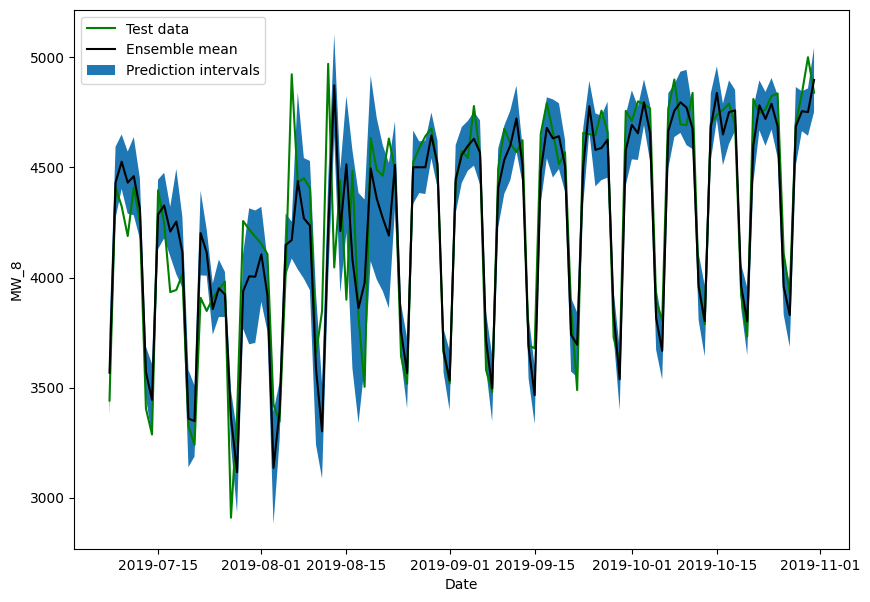

In [ ]:
# Plot estimated (normally distributed) prediction intervals for mean.
offset=600
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], 'g', label='Test data') #True test labels
plt.plot(X_test.index[offset:], ensemble_mean[offset:], 'k-', label='Ensemble mean')# mean ensemble forecasted labels from windowed dataset
plt.xlabel('Date')
plt.ylabel('MW_8')
plt.fill_between(X_test.index[offset:],
                (lower)[offset:],
                (upper)[offset:], label='Prediction intervals')
plt.legend()

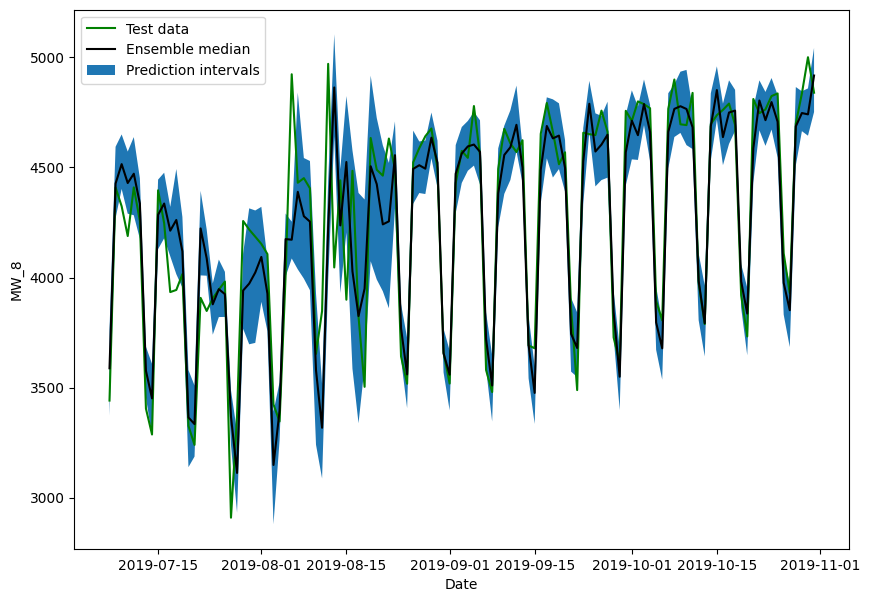

In [ ]:
# Plot estimated (normally distributed) prediction intervals for median.
offset=600
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], 'g', label='Test data')
plt.plot(X_test.index[offset:], ensemble_median[offset:], 'k-', label='Ensemble median')
plt.xlabel('Date')
plt.ylabel('MW_8')
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label='Prediction intervals')
plt.legend()

# (F) Future univariate model (W:28/H:1/F:14)
Make future forecasts on entire univariate dataset, while retraining the model before each prediction.

In [ ]:
WINDOW_SIZE = 28
HORIZON = 1
FUTURE_HORIZON = 56
EPOCHS = 100

In [ ]:
def get_model(horizon=HORIZON):
  model = tf.keras.Sequential([
      layers.Lambda(lambda x :tf.expand_dims(x, axis=1)),
      layers.Conv1D(128, 5, padding='causal', activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(horizon)], name='model_future_all')
  model.compile(loss=tf.keras.losses.mae, optimizer=tf.keras.optimizers.Adam())

  return model

In [ ]:
all_windows, all_labels = make_windows(mw_8, window_size=WINDOW_SIZE, horizon=HORIZON)

##Function to make future retrainable predictions on entire data

In [ ]:
def make_retrainable_preds(labels, windows, model, future_horizon, window_size, horizon, epochs):
  '''
  This function trains a model for every updated predictions.
  Arguments:
      - labels: MW8 labels from windowed data (here all_labels).
      - windows: MW8 windowed data (here all_windows).
      - model: compiled model (here get_model).
      - future_horizon: number of timesteps to predict into real future.
      - window_size: default of 7.
      - horizon: default of 1 (called by model).
  Returns:
      - model --> model trained on data and previous predictions.
  '''
  future_forecasts = []
  last_window = labels[-window_size:]# Use labels to get non-windowed array
  X_all = windows
  y_all = labels

  for _ in range(future_horizon):
      # Each updated data are trained for 5 epochs
      model.fit(x=X_all, y=y_all, epochs=epochs, verbose=0) # Fit function uses lower case 'x'
      predictions = model.predict(tf.expand_dims(last_window, axis=0))
      print(f'Predicing on: \n {last_window} --> Prediction: {tf.squeeze(predictions).numpy()}\n')
      future_forecasts.append(tf.squeeze(predictions).numpy())

      for i in range(0 , len(X_all)):
        x = X_all[i][1:]  # remove the 0th index of windows/add 'i' for windowed array
        y = y_all[1:] # remove the 0th index of labels
        windows = np.append(x, predictions) # append predictions to windows
        labels = np.append(y, predictions) # append predictions to labels

      # Update the last window
      last_window = np.append(last_window, predictions)[-window_size:]

  return model, future_forecasts

In [ ]:
# First window starts on 2019-10-04 and ends 2019-10-31 (last true label)
model_future_trained = make_retrainable_preds(labels=tf.squeeze(all_labels),
                                              windows=all_windows,
                                              model=get_model(horizon=HORIZON),
                                              window_size=WINDOW_SIZE,
                                              horizon=HORIZON,
                                              epochs=EPOCHS,
                                              future_horizon=FUTURE_HORIZON)

1/1 [==============================] - 0s 181ms/step
Predicing on: 
 [4769.06 3893.63 3805.67 4766.42 4899.72 4696.19 4692.56 4838.89 3975.06
 3788.72 4697.6  4737.62 4761.78 4790.36 4693.61 3920.18 3732.69 4811.2
 4746.71 4764.01 4824.43 4836.3  4110.29 3929.79 4699.64 4836.49 5000.82
 4839.68] --> Prediction: 4561.80859375

1/1 [==============================] - 0s 33ms/step
Predicing on: 
 [3893.63       3805.67       4766.42       4899.72       4696.19
 4692.56       4838.89       3975.06       3788.72       4697.6
 4737.62       4761.78       4790.36       4693.61       3920.18
 3732.69       4811.2        4746.71       4764.01       4824.43
 4836.3        4110.29       3929.79       4699.64       4836.49
 5000.82       4839.68       4561.80859375] --> Prediction: 4436.73779296875

1/1 [==============================] - 0s 23ms/step
Predicing on: 
 [3805.67       4766.42       4899.72       4696.19       4692.56
 4838.89       3975.06       3788.72       4697.6        4737.62
 476

##Plot future forecasts

In [ ]:
future_forecasts = model_future_trained[1]
future_forecasts

[4561.8086,
 4436.738,
 4486.6167,
 4590.4517,
 4545.263,
 4488.512,
 4445.1436,
 4431.196,
 4376.9937,
 4422.7676,
 4505.434,
 4467.435,
 4464.723,
 4438.394,
 4416.343,
 4380.9824,
 4408.415,
 4527.8384,
 4491.2314,
 4484.526,
 4486.8774,
 4513.41,
 4473.8374,
 4473.578,
 4525.74,
 4505.559,
 4479.528,
 4439.7397,
 4407.5815,
 4411.1914,
 4477.192,
 4477.16,
 4477.0835,
 4477.0005,
 4477.155,
 4477.0815,
 4477.001,
 4477.1523,
 4477.08,
 4477.1206,
 4477.053,
 4477.201,
 4477.0137,
 4477.1675,
 4477.106,
 4477.061,
 4477.03,
 4477.21,
 4477.176,
 4477.137,
 4477.1187,
 4477.224,
 4477.2285,
 4477.021,
 4477.047,
 4477.077]

In [ ]:
def get_future_dates(start_date, future_horizon, offset=1):

  start_date = start_date + np.timedelta64(offset, 'D')# specify start date, "D" for day, here y_all.tail(1)
  end_date = start_date + np.timedelta64(future_horizon, 'D')# specify end date

  return np.arange(start_date, end_date, dtype='datetime64[D]')# return a date range between start and end date

In [ ]:
# Last timestep is of np.datetime64 format
last_timestep = y.index[-1]
last_timestep

Timestamp('2019-10-31 00:00:00')

In [ ]:
# Get next two week of timesteps
next_timesteps = get_future_dates(start_date=last_timestep,
                                   future_horizon=FUTURE_HORIZON)
next_timesteps

array(['2019-11-01', '2019-11-02', '2019-11-03', '2019-11-04',
       '2019-11-05', '2019-11-06', '2019-11-07', '2019-11-08',
       '2019-11-09', '2019-11-10', '2019-11-11', '2019-11-12',
       '2019-11-13', '2019-11-14', '2019-11-15', '2019-11-16',
       '2019-11-17', '2019-11-18', '2019-11-19', '2019-11-20',
       '2019-11-21', '2019-11-22', '2019-11-23', '2019-11-24',
       '2019-11-25', '2019-11-26', '2019-11-27', '2019-11-28',
       '2019-11-29', '2019-11-30', '2019-12-01', '2019-12-02',
       '2019-12-03', '2019-12-04', '2019-12-05', '2019-12-06',
       '2019-12-07', '2019-12-08', '2019-12-09', '2019-12-10',
       '2019-12-11', '2019-12-12', '2019-12-13', '2019-12-14',
       '2019-12-15', '2019-12-16', '2019-12-17', '2019-12-18',
       '2019-12-19', '2019-12-20', '2019-12-21', '2019-12-22',
       '2019-12-23', '2019-12-24', '2019-12-25', '2019-12-26'],
      dtype='datetime64[D]')

In [ ]:
#NB: RUN ONLY ONCE OR RERUN FUNCTION
# Get a smooth plot by adding last timestep/final price into next time steps and future forecasts
next_timesteps = np.insert(next_timesteps, 0, last_timestep)# Insert last timestep at 0'th index to join forecasts with data below
future_forecasts = np.insert(future_forecasts, 0, y[-1])

#next_time_steps, future_forecast
next_timesteps, future_forecasts

(array(['2019-10-31', '2019-11-01', '2019-11-02', '2019-11-03',
        '2019-11-04', '2019-11-05', '2019-11-06', '2019-11-07',
        '2019-11-08', '2019-11-09', '2019-11-10', '2019-11-11',
        '2019-11-12', '2019-11-13', '2019-11-14', '2019-11-15',
        '2019-11-16', '2019-11-17', '2019-11-18', '2019-11-19',
        '2019-11-20', '2019-11-21', '2019-11-22', '2019-11-23',
        '2019-11-24', '2019-11-25', '2019-11-26', '2019-11-27',
        '2019-11-28', '2019-11-29', '2019-11-30', '2019-12-01',
        '2019-12-02', '2019-12-03', '2019-12-04', '2019-12-05',
        '2019-12-06', '2019-12-07', '2019-12-08', '2019-12-09',
        '2019-12-10', '2019-12-11', '2019-12-12', '2019-12-13',
        '2019-12-14', '2019-12-15', '2019-12-16', '2019-12-17',
        '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-21',
        '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
        '2019-12-26'], dtype='datetime64[D]'),
 array([4839.68  , 4561.8086, 4436.738 , 4486.6167, 4590.

## Create plot function

In [ ]:
def plot_time_series(timesteps, values, format="-", start=0, end=None, label=None):
  """
  Plots values across timesteps.

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of time series values
  format : style of plot, default set at "-"
  start : the plot indexes from the start of timesteps and values
  end : where to end the plot
  label : label describing values, default set at None
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Dates")
  plt.ylabel("MW")
  plt.xticks(rotation=45)
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

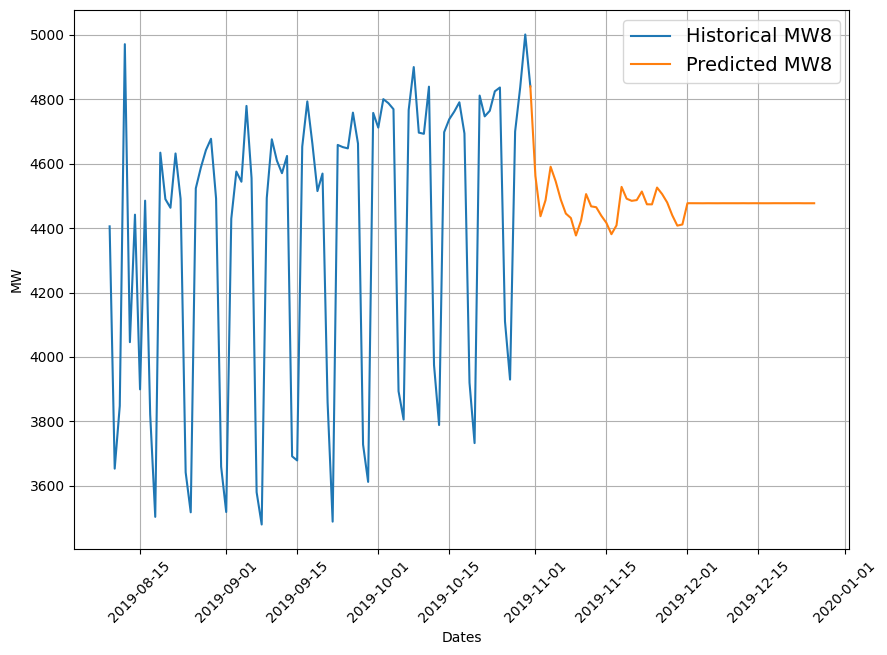

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(y.index, y, start=3500, format='-', label='Historical MW8')
plot_time_series(next_timesteps, future_forecasts, format='-', label='Predicted MW8')

## Compare models

In [ ]:
# Compare different model results
model_results = pd.DataFrame({'Conv1D 28:1':model_Conv1D_results,
                              'TF 28:1': tf_model_results,
                              'N-BEATS 7:1': model_NBEATS_results,
                              'Multivariate 28:1': model_multivariate_results,
                              'Ensemble 1 7:1': model_ensemble_results,
                              'Ensemble 2 7:1': model_ensemble_results_2
                              }).T # transpose to format correctly
model_results

,mae,mse,rmse,mape
Conv1D 28:1,149.008286,53096.089844,230.425888,3.388910
TF 28:1,484.703552,351816.062500,593.140869,11.630136
N-BEATS 7:1,193.466202,81015.054688,284.631439,4.430746
Multivariate 28:1,147.743729,50813.210938,225.417862,3.374846
Ensemble 1 7:1,183.701126,73328.359375,270.792084,4.176787
Ensemble 2 7:1,184.345490,73117.851562,270.403137,4.197385


<Axes: >

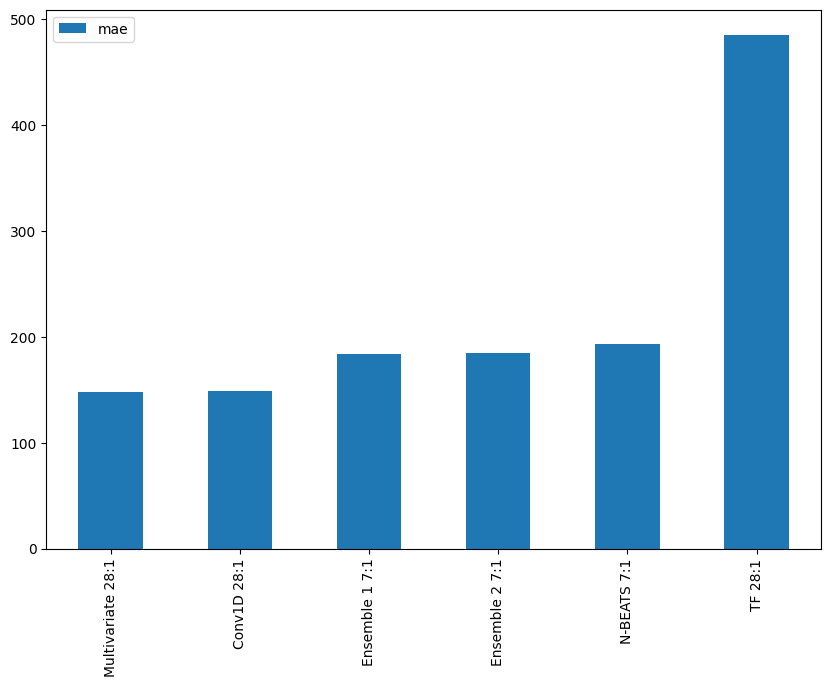

In [ ]:
model_results[['mae']].sort_values(by='mae').plot(figsize=(10,7), kind='bar')

# EXTRA
- Try hybrid/tribid model - Use plot_model()
- Try Kats, N-HITS